In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l
import time
import pathlib
data_dir = 'C:/Users/eaind/ocr/13Sep21Model/cnnpro/data'

def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(39)])  ##Classes


X = tf.random.uniform((1, 224, 224, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)
    
    


Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Conv2D output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 256)
MaxPooling2D output shape:	 (1, 5, 5, 256)
Flatten output shape:	 (1, 6400)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 39)


In [3]:
##----##   
    
img_height, img_width = 224, 224 
batch_size = 256

train_iter = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_iter = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 21897 files belonging to 39 classes.
Using 17518 files for training.
Found 21897 files belonging to 39 classes.
Using 4379 files for validation.


In [4]:
##----##


class TrainCallback(tf.keras.callbacks.Callback):  
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name
    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()
    def on_epoch_end(self, epoch, logs):
        if(logs.get('loss')<0.02):
            print("\nReached 98% accuracy so cancelling training!")
            self.net.stop_training = True
        self.timer.stop()
        test_acc = self.net.evaluate(self.test_iter, verbose=0, return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, 'f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on 'f'{str(self.device_name)}')


def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs, device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net


loss 0.348, train acc 0.902, test acc 0.925
12.8 examples/sec on /CPU:0


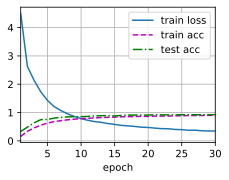

In [5]:
##----##

lr, num_epochs = 0.001, 30
model = train_ch6(net, train_iter, val_iter, num_epochs, lr, d2l.try_gpu())

In [6]:
model.save('savemodel/alexnet_ep30lr0p001bs256m.h5')

In [7]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 12, 12, 256)      